In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [2]:
def trend(time, slope=0):
    return slope*time

def seasonal_pattern(season_time):
    return np.where(season_time < 0.1,
                    np.cos(season_time * 7 * np.pi),
                    1 / np.exp(5 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time))*noise_level

def plot_series(time, series, format="-", title="", label=None, start=0, end=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.title(title)
    if label:
        plt.legend()
    plt.grid(True)

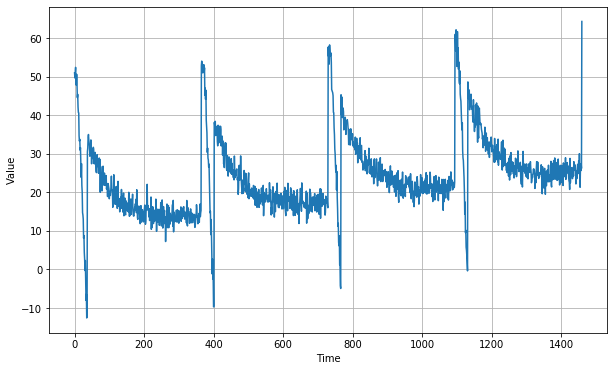

In [4]:
TIME = np.arange(4*365+1, dtype="float32")
y_intercept = 10
slope = 0.01
SERIES = trend(TIME, slope)+y_intercept

amplitude = 40
SERIES+=seasonality(TIME, period=365,amplitude=amplitude)

noise_level = 2
SERIES+=noise(TIME, noise_level, seed=42)

plt.figure(figsize=(10, 6))
plot_series(TIME, SERIES)
plt.show()


In [5]:
SPLIT_TIME = 1100

def train_val_split(time, series, time_step=SPLIT_TIME):
    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step: ]
    return time_train, series_train, time_valid, series_valid

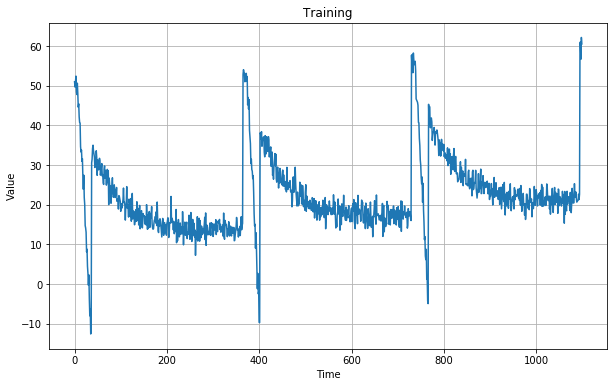

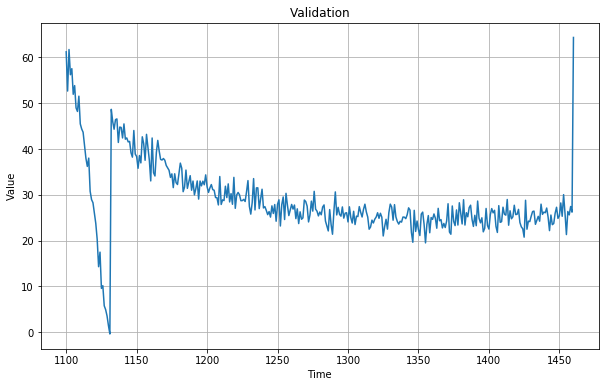

In [6]:
time_train, series_train, time_valid, series_valid = train_val_split(TIME, SERIES)

plt.figure(figsize=(10, 6))
plot_series(time_train, series_train, title="Training")
plt.show()

plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid, title="Validation")
plt.show()

In [7]:
def compute_metrics(true_series, forecast):
    mse = tf.keras.metrics.mean_squared_error(true_series, forecast)
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast)
    return mse, mae

In [8]:
zeros = np.zeros(5)
ones = np.ones(5)

mse, mae= compute_metrics(zeros, ones)
print(mse, mae)

tf.Tensor(1.0, shape=(), dtype=float64) tf.Tensor(1.0, shape=(), dtype=float64)


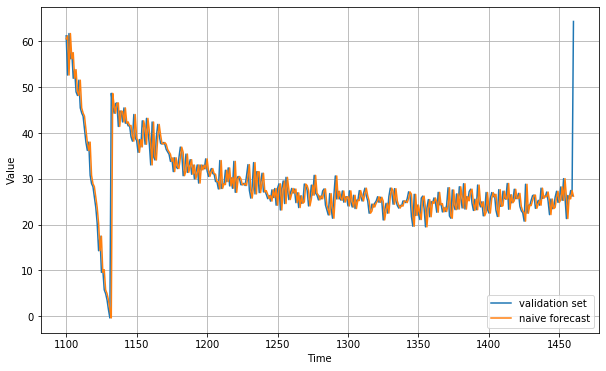

In [9]:
naive_forecast = SERIES[SPLIT_TIME -1:-1]
plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid, label="validation set")
plot_series(time_valid, naive_forecast, label="naive forecast")

In [10]:
def moving_average_forecast(series, window_size):
    forecast = []

    for time in range(len(series) - window_size):
        forecast.append(series[time:time+window_size].mean())

    np_forecast = np.array(forecast)
    return np_forecast

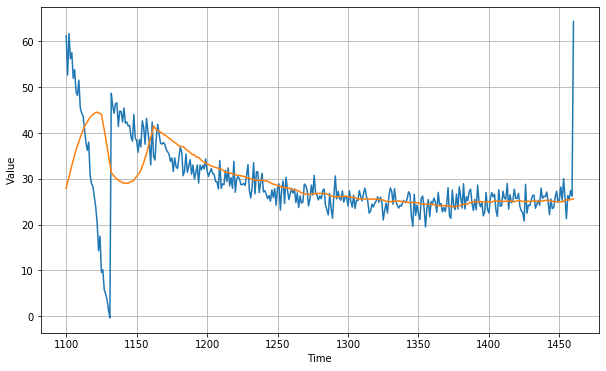

In [12]:
moving_avg = moving_average_forecast(SERIES, window_size=30)
moving_avg = moving_avg[1100-30:]
plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, moving_avg)

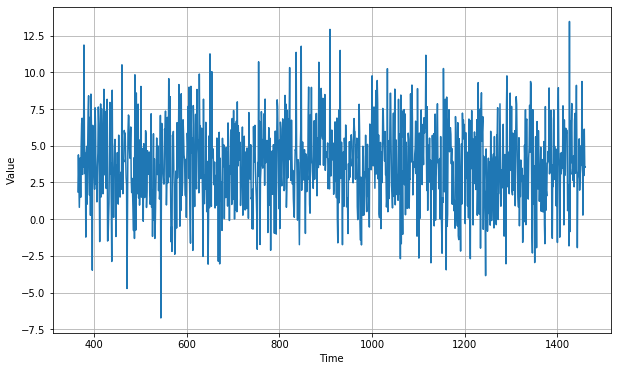

In [16]:
diff_series = SERIES[365:]-SERIES[:-365]
diff_time = TIME[365:]

plt.figure(figsize=(10, 6))
plot_series(diff_time, diff_series)
plt.show()

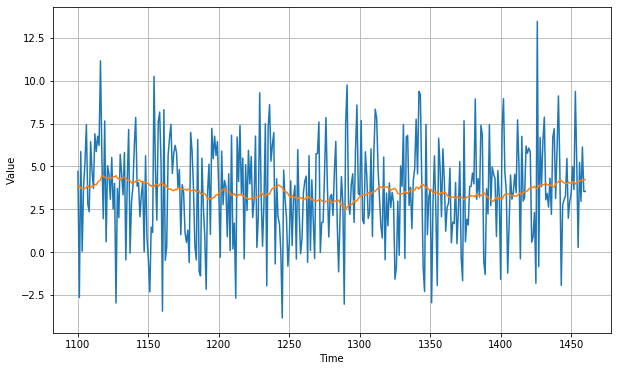

In [24]:
diff_moving_avg = moving_average_forecast(diff_series, 50)

diff_moving_avg = diff_moving_avg[SPLIT_TIME - 365 - 50:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, diff_series[1100 - 365:])
plot_series(time_valid, diff_moving_avg)
plt.show()

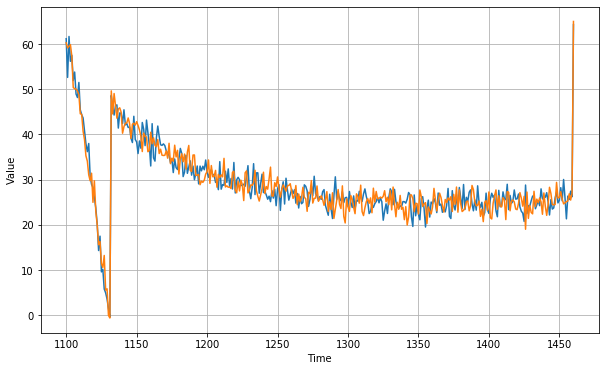

In [25]:
past_series = SERIES[SPLIT_TIME-365:-365]

diff_moving_avg_plus_past= past_series+diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, diff_moving_avg_plus_past)
plt.show()

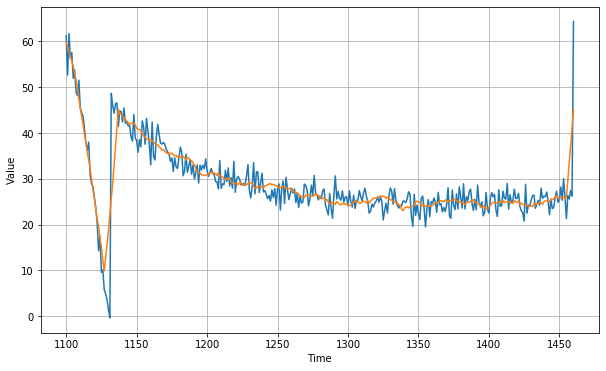

In [28]:
smooth_past_series = moving_average_forecast(SERIES[SPLIT_TIME - 370:-360], 10)

diff_moving_avg_plus_smooth_past = smooth_past_series+diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, diff_moving_avg_plus_smooth_past)
plt.show()